<a href="https://colab.research.google.com/github/alfianhid/Klasifikasi-Penyakit-Pada-Tanaman-Apel-Berdasarkan-Citra-Daun-Menggunakan-Algoritma-CNN/blob/main/Klasifikasi_Penyakit_Pada_Tanaman_Apel_Berdasarkan_Citra_Daun_Menggunakan_Algoritma_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Menghubungkan Google Colab ke Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Mengekstrak dataset zip dari Google Drive**

In [ ]:
import os 
from os import listdir
import zipfile

local_zip = "/content/drive/My Drive/dataset.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/content/drive/My Drive/workspace")
zip_ref.close()

In [ ]:
# Memeriksa apakah dataset sudah terekstrak dengan benar
!ls "/content/drive/My Drive/workspace/dataset"

train  val


**Impor beberapa library yang diperlukan**

In [ ]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

**Memproses dataset yang telah diekstrak**

In [ ]:
# dimensi gambar resized
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# jumlah gambar yang akan digunakan
N_IMAGES = 1000

# Path folder dataset
root_dir = '/content/drive/My Drive/workspace/dataset'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

**Membuat fungsi untuk me-resize dimensi gambar**

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

**Membuat fungsi untuk memproses folder gambar**

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Sedang memproses gambar...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Memproses folder {plant_disease_folder}...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Berhasil memproses seluruh gambar.")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Jumlah seluruh gambar: {image_len}")

[INFO] Sedang memproses gambar...
[INFO] Memproses folder daun_apel_black_rot...
[INFO] Memproses folder daun_apel_cedar_rust...
[INFO] Memproses folder daun_apel_healthy...
[INFO] Memproses folder daun_apel_scab...
[INFO] Berhasil memproses seluruh gambar.

Jumlah seluruh gambar: 2220


**Menampilkan jumlah kelas gambar**

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Jumlah kelas gambar: ", n_classes)

Jumlah kelas gambar:  4


**Melakukan augmentasi data untuk mendapatkan performa yang optimal**

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

**Split dataset dengan proporsi 80:20**

In [ ]:
print("[INFO] Membagi dataset menjadi data latih dan data uji...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=45) 

[INFO] Membagi dataset menjadi data latih dan data uji...


**Membangun model pengklasifikasi**

In [ ]:
# Atur beberapa parameter pada model
EPOCHS = 10
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

**Membuat model dengan menambahkan fitur Convolutional, Normalization, Pooling, Dropout, dan Activation layer**

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)       

**Melakukan pelatihan terhadap model**

In [ ]:
# Mengaktifkan optimizer
opt = Adam(learning_rate=LR, decay=LR/EPOCHS)

# meng-compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# melatih model
print("[INFO] Sedang melatih model...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                    epochs=EPOCHS, verbose=1)

[INFO] Sedang melatih model...
Epoch 1/10
55/55 [==============================] - 370s 7s/step - loss: 0.0980 - accuracy: 0.9374 - val_loss: 1.2378 - val_accuracy: 0.7523
Epoch 2/10
55/55 [==============================] - 360s 7s/step - loss: 0.1340 - accuracy: 0.9346 - val_loss: 0.1838 - val_accuracy: 0.9392
Epoch 3/10
55/55 [==============================] - 368s 7s/step - loss: 0.0710 - accuracy: 0.9601 - val_loss: 0.2177 - val_accuracy: 0.9279
Epoch 4/10
55/55 [==============================] - 362s 7s/step - loss: 0.0959 - accuracy: 0.9290 - val_loss: 1.0133 - val_accuracy: 0.6757
Epoch 5/10
55/55 [==============================] - 373s 7s/step - loss: 0.0778 - accuracy: 0.9431 - val_loss: 0.4406 - val_accuracy: 0.7995
Epoch 6/10
55/55 [==============================] - 363s 7s/step - loss: 0.0744 - accuracy: 0.9559 - val_loss: 1.5622 - val_accuracy: 0.5405
Epoch 7/10
55/55 [==============================] - 362s 7s/step - loss: 0.1137 - accuracy: 0.9272 - val_loss: 0.6084 - val

**Mem-plot nilai akurasi dan loss pada hasil pelatihan model**

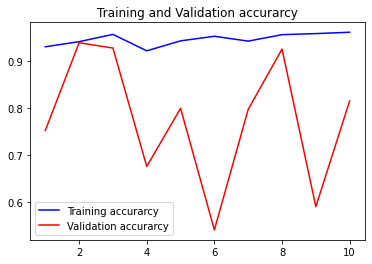

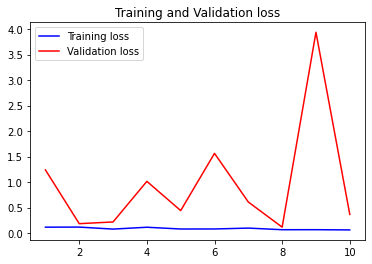

In [ ]:
# Mendefinisikan variabel
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Akurasi data latih dan data uji
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Loss data latih dan data uji
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

**Mengukur performa model**

In [ ]:
print("[INFO] Menghitung akurasi model...")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Menghitung akurasi model...
14/14 [==============================] - 19s 1s/step - loss: 0.3657 - accuracy: 0.8153
Test Accuracy: 81.5315306186676


**Menyimpan model untuk digunakan dalam tahap prediksi**

In [ ]:
# Hotfix function
def make_keras_picklable():
    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

In [ ]:
# Menjalankan fungsi yang telah didefinisikan
make_keras_picklable()

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


**Menguji model pengklasifikasi**

In [ ]:
# Membuat fungsi untuk prediksi gambar
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


daun_apel_black_rot


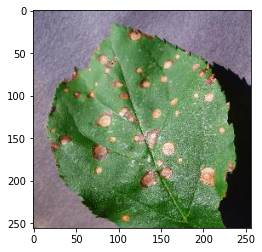

In [ ]:
predict_disease('/content/drive/My Drive/workspace/dataset/val/daun_apel_black_rot/e4d473a3-83ad-496d-a97f-5aee9d713d69___JR_FrgE.S 2782.JPG')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


daun_apel_cedar_rust


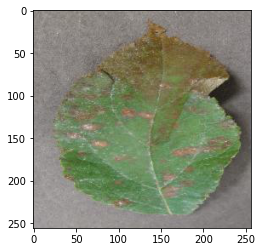

In [ ]:
predict_disease('/content/drive/My Drive/workspace/dataset/val/daun_apel_cedar_rust/1e099d8e-b40c-4cf3-bb52-4e77b5a2dc69___FREC_C.Rust 0155.JPG')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


daun_apel_healthy


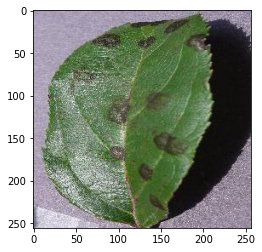

In [ ]:
predict_disease('/content/drive/My Drive/workspace/dataset/val/daun_apel_scab/d8b8a834-08df-43d9-8a1a-4bc8e508a1e3___FREC_Scab 3280.JPG')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


daun_apel_healthy


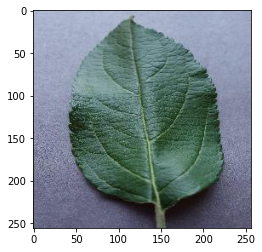

In [ ]:
predict_disease('/content/drive/My Drive/workspace/dataset/val/daun_apel_healthy/f591e5cc-e9fc-4d82-b2cd-09ab19cb4581___RS_HL 7829.JPG')